# (Mostly) From Scratch Decoder-Only Transformer for Next Word Prediction
Currently unfinished. The model is implemented and can fit the training data, but does not generalize and suffers from overfitting. This is likely due to the lazy first attempt at set up trainig data. Hyperparameter selection should be performed as well. Will need to improve.


In [ ]:
#! pip install keras-nlp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keras_nlp
from matplotlib import pyplot as plt


Data

Download the data

In [ ]:
data_url = "https://www.gutenberg.org/cache/epub/67138/pg67138.txt"

dataset_dir = keras.utils.get_file(origin = data_url)

In [ ]:
dataset_dir

'/root/.keras/datasets/pg67138.txt'

Clean the data

In [ ]:
import re
import nltk
import string

In [ ]:
lines = []
start = False
with open("turing.txt") as datafile:
  for line in datafile:
    # if start:
    lines.append(line)
    # else:
    #   if "Robert Cohn was once middleweight boxing" in line:
    #     start = True
    #     lines.append(line)

raw_text = ""
for line in lines:
  raw_text = ' '.join(lines)

In [ ]:
lines

['I PROPOSE to consider the question, ‘Can machines think?’ This should begin with definitions of the meaning of the terms ‘machine’ and ‘think’. The definitions might be framed so as to reflect so far as possible the normal use of the words, but this attitude is dangerous. If the meaning of the words ‘machine’ and ‘think’ are to be found by examining how they are commonly used it is difficult to escape the conclusion that the meaning and the answer to the question, ‘Can machines think?’ is to be sought in a statistical survey such as a Gallup poll. But this is absurd. Instead of attempting such a definition I shall replace the question by another, which is closely related to it and is expressed in relatively unambiguous words.\n',
 '\n',
 'The new form of the problem can be described in terms of a game which we call the ‘imitation game’. It is played with three people, a man (A), a woman (B), and an interrogator (C) who may be of either sex. The interrogator stays in a room apart from

In [ ]:
# Remove extra spaces
text = re.sub("\s+", " ", raw_text)

# #remove punctuations
# text = re.sub("[^-9A-Za-z ]", "" , text)

#lower case
text = text.lower()

#tokenize
nltk.download("punkt")
tokens = nltk.tokenize.word_tokenize(text)

print(tokens[:50])

tokenizer = keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(tokens)
tokenizer.word_index
one_hots = tokenizer.texts_to_matrix(tokens)
tokens = tokenizer.texts_to_sequences(tokens)
vocab_size = len(tokenizer.word_index)
# tokens[0:10]
# vectorize_layer = layers.TextVectorization(
#     standardize=None,
#     max_tokens=vocab_size,
#     output_mode='multi_hot'
#     )

# tokens = vectorize_layer(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'propose', 'to', 'consider', 'the', 'question', ',', '‘', 'can', 'machines', 'think', '?', '’', 'this', 'should', 'begin', 'with', 'definitions', 'of', 'the', 'meaning', 'of', 'the', 'terms', '‘', 'machine', '’', 'and', '‘', 'think', '’', '.', 'the', 'definitions', 'might', 'be', 'framed', 'so', 'as', 'to', 'reflect', 'so', 'far', 'as', 'possible', 'the', 'normal', 'use', 'of', 'the']


In [ ]:
len(tokens)

13222

In [ ]:
def gen_samples(n_samples, sample_length):
  max_sample = len(tokens)-sample_length-1
  samples = {'x':[], 'y':[]}
  for i in range(n_samples):
    start = np.random.randint(0, max_sample)
    samples['x'].append(tokens[start:start+sample_length])
    samples['y'].append(one_hots[sample_length+1])
  samples['x'] = np.array(samples['x'])
  samples['x'].resize(n_samples, sample_length)
  samples['y'] = np.array(samples['y'])
  samples['y'].resize(n_samples, vocab_size)
  return samples['x'], samples['y']

In [ ]:
x, y = gen_samples(2, 10)
x.resize(1, 10)
y.shape

(2, 2060)

Hyperparameters

In [ ]:

src_pad_idx = 0
embed_size = 512
num_layers = 4
forward_expansion = 4
heads = 4
dropout = 0.1
length = 50
warmup_steps = 4000

Make mask

In [ ]:
def create_look_ahead_mask(len):
  mask = 1 - tf.linalg.band_part(tf.ones((len, len)), -1, 0)
  return mask

In [ ]:
create_look_ahead_mask(embed_size//heads)

<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Input, embedding, and positional encoding

In [ ]:
input = keras.Input(shape=(None,), name="sequence input")
vectorized = layers.TextVectorization()
embedding = layers.Embedding(vocab_size,  embed_size, name="Embedding")(input)
# range = keras.backend.te
# pos_encoding = layers.Embedding(length, embed_size, name="Positional_Encoding")(tf.range(length))
pos_encoding = keras_nlp.layers.PositionEmbedding(length)(embedding)
x = layers.Add(name="Add")([embedding, pos_encoding])
x = layers.Dropout(dropout)(x)

Decoder Blocks

In [ ]:
mask = create_look_ahead_mask(length)


assert embed_size % heads == 0
for i in range(num_layers):
  mha = layers.MultiHeadAttention(heads, embed_size, dropout=dropout, name="mha"+str(i))(x, x, attention_mask = mask)
  drop = layers.Dropout(dropout)(mha)
  x = layers.add([x, drop])
  x = layers.LayerNormalization(name="AttnLayerNorm"+str(i))(x)
  dense = layers.Dense(embed_size*forward_expansion, name="ForwardExpansion"+str(i))(x)
  dense2 = layers.Dense(embed_size, name="Dense"+str(i))(dense)
  drop = layers.Dropout(dropout)(dense2)
  x = layers.add([x, drop])
  x = layers.LayerNormalization(name="DenseLayerNorm"+str(i))(x)

Final layer

In [ ]:
x = x[:, -1, :]
x = layers.Dense(vocab_size, name="FinalDense")(x)
output= layers.Softmax(name="Softmax")(x)

Make model

In [ ]:
model = keras.Model(input, output)

In [ ]:
# keras.utils.plot_model(model, "Transformer.png")

Custom learning rate scheduler

In [ ]:
class TransformerScheduler(keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps):
    self.d_model = d_model
    self.warmup_steps = warmup_steps
    self.initial_learning_rate = 1e-7

  def __call__(self, step):
    return self.d_model**(-.5)*tf.minimum(step**-0.5, step*self.warmup_steps**-1.5)
  
  def test_call(self, step):
    return self.d_model**(-.5)*min(step**-0.5, step*self.warmup_steps**-1.5)

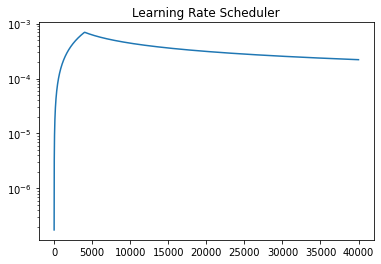

In [ ]:
ts = TransformerScheduler(embed_size, warmup_steps)
schedule = [ts.test_call(i) for i in range(1,40000)]
plt.plot(schedule)
plt.title('Learning Rate Scheduler')
plt.yscale('log')
plt.show()

Compile the model

In [ ]:
opt = keras.optimizers.Adam(TransformerScheduler(embed_size, warmup_steps), beta_2=0.98, epsilon=1e-9)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(opt)

model.compile(
    optimizer=opt,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['acc', lr_metric, keras.metrics.TopKCategoricalAccuracy()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 Embedding (Embedding)          (None, None, 512)    1054720     ['sequence input[0][0]']         
                                                                                                  
 position_embedding (PositionEm  (None, None, 512)   25600       ['Embedding[0][0]']              
 bedding)                                                                                         
                                                                                                  
 Add (Add)                      (None, None, 512)    0           ['Embedding[0][0]',          

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

Generate samples and fit

In [ ]:
num_samples = 10000
x, y = gen_samples(num_samples, length)
# model.load_weights(checkpoint_filepath)
model.fit(x, y, batch_size=128, epochs=10000, validation_split=.3, callbacks=[model_checkpoint_callback])

Epoch 1/10000
55/55 [==============================] - 14s 262ms/step - loss: 7.8199 - acc: 4.2857e-04 - lr: 9.6081e-06 - top_k_categorical_accuracy: 0.0023 - val_loss: 7.7801 - val_acc: 0.0000e+00 - val_lr: 1.4325e-05 - val_top_k_categorical_accuracy: 0.0017
Epoch 2/10000
55/55 [==============================] - 13s 234ms/step - loss: 7.7702 - acc: 1.4286e-04 - lr: 1.9216e-05 - top_k_categorical_accuracy: 0.0020 - val_loss: 7.7492 - val_acc: 3.3333e-04 - val_lr: 2.3933e-05 - val_top_k_categorical_accuracy: 0.0023
Epoch 3/10000
55/55 [==============================] - 13s 234ms/step - loss: 7.7247 - acc: 1.4286e-04 - lr: 2.8824e-05 - top_k_categorical_accuracy: 0.0023 - val_loss: 7.7295 - val_acc: 0.0000e+00 - val_lr: 3.3541e-05 - val_top_k_categorical_accuracy: 0.0013
Epoch 4/10000
55/55 [==============================] - 13s 234ms/step - loss: 7.6596 - acc: 8.5714e-04 - lr: 3.8432e-05 - top_k_categorical_accuracy: 0.0041 - val_loss: 7.7501 - val_acc: 0.0013 - val_lr: 4.3149e-05 - val